In [2]:
%load_ext autoreload

In [5]:
%autoreload 2
import os
import re

import yaml
import h5py
import numpy as np
import pandas as pd
from scipy.io import wavfile
from IPython.display import display, Audio

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import features.hdf5_iterator
from features.data_preprocessing import make_stft_features
from features.mixer import FeatureMixer
from utils.postprocessing import reconstruct

with open('some-data.yml') as f:
    some_data = yaml.safe_load(f)
data_dir = some_data['data_dir']
hdf5_dest = some_data['hdf5_dest']

dvds = [os.path.join(data_dir, 'DVD+R#{}'.format(i)) for i in range(1,4)]
rooms = [[os.path.join(dvd, room) for room in os.listdir(dvd) if re.search(r'.+Room[0-9]+', room) is not None] for dvd in dvds]
# flattening list, sorry
room_paths = [room for rooms_prime in rooms for room in rooms_prime]
wavs = { os.path.basename(room): sorted([os.path.join(room,wav) 
                                        for wav in os.listdir(room) if wav[-4:] == '.wav']) 
                                        for room in room_paths }
sources = {'LargeRoom08-0103':
          ['White noise',
'M1',
'M2',
'F1',
'F2',
'Music',
'M1',
'F1',
'M2',
'F2',
'White noise',
'White noise',
'White noise',
'White noise',
'M2',
'Three person conversation',
'M1',
'F1',
'F1',
'F2'],
      'MediumRoom07-1227': [
          'White noise',
'F1',
'F2',
'M1',
'M1',
'Four person conversation',
'Music',
'M2',
'F1',
'F2',
'White noise',
'White noise',
'M2',
'M1',
'White noise',
'White noise',
'F2',
'F1',
'M2',
'M1'
      ],
        'SmallRoom08-0104'  :
          ['Back Ground',
'White Noise',
'M1',
'M2',
'F1',
'F2',
'Music',
'M1',
'M1',
'White Noise',
'White Noise',
'F1',
'Source',
'F1',
'M2',
'White Noise',
'White Noise',
'F2',
'M2',
'M1',
'F2',
'F1']}

/opt/conda/envs/magnolia3/lib/python3.5/site-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


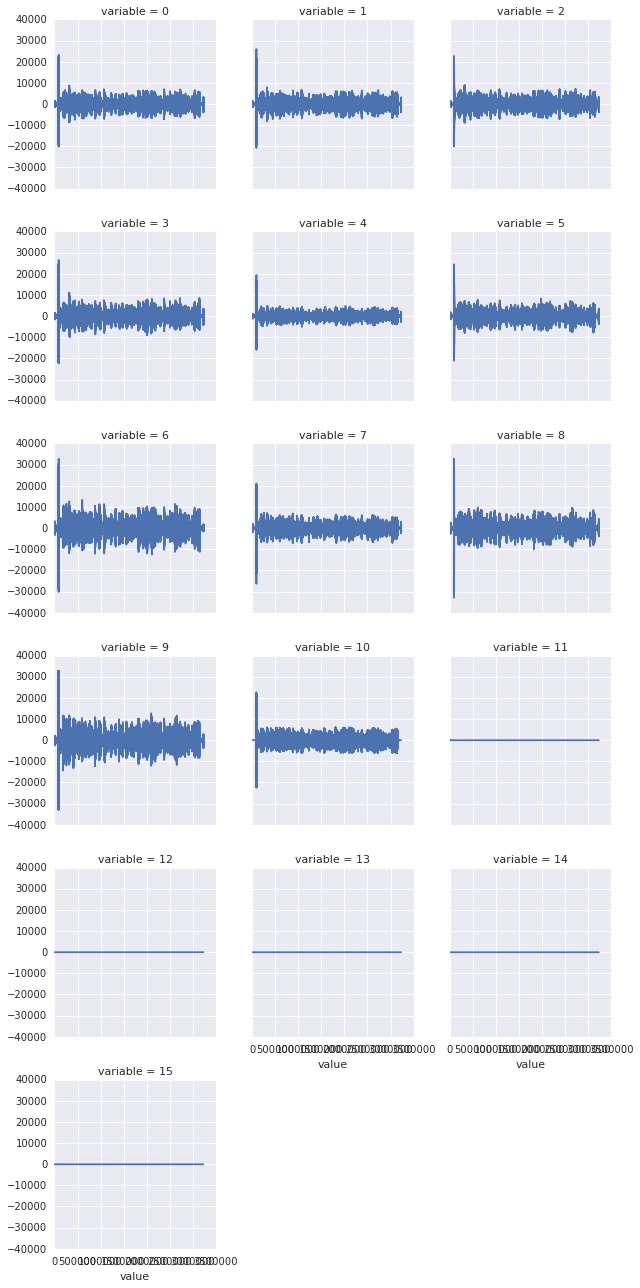

In [7]:
fs, wav = wavfile.read(np.random.choice(wavs['MediumRoom07-1227']))
wav_df = pd.DataFrame.from_records(wav)
wav_long = pd.melt(wav_df)
wav_long.columns

grd = sns.FacetGrid(wav_long, col='variable', col_wrap=3)
grd.map(plt.plot, 'value')

In [7]:
for room in wavs:
    for wav_path, source in zip(wavs[room], sources[room]):
        print(source, ":", wav_path)
        filename = os.path.basename(wav_path).lower()[:-4]
        with h5py.File(os.path.join(hdf5_dest, "{}.h5".format(filename)), 'w') as f:
            g = f.create_group(source)
            fs, wav = wavfile.read(wav_path)
            specs = [make_stft_features(wav[:,mic], fs, 10000.0) for mic in range(11)]
            specs = np.stack(specs,-1)
            g.create_dataset(filename, data=specs)

Back Ground : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small001.wav


/opt/conda/envs/magnolia3/lib/python3.5/site-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


White Noise : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small002.wav
M1 : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small003.wav
M2 : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small004.wav
F1 : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small005.wav
F2 : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small006.wav
Music : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small007.wav
M1 : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small008.wav
M1 : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small009.wav
White Noise : /local_data/teams/magnolia/gfe-data/GFE Data/_2008_Audio_Set/DVD+R#3/SmallRoom08-0104/Small010.wav
White Noise : /local_data/teams/magnolia/gf

In [8]:
hdf5_files = os.listdir(hdf5_dest)
test_file_1 = os.path.join(hdf5_dest,np.random.choice(hdf5_files))
test_file_2 = os.path.join(hdf5_dest,np.random.choice(hdf5_files))


fmix = FeatureMixer((test_file_1, test_file_2), shape=(100,None))
mix, wav1, wav2 = next(fmix)
mix_t = reconstruct(mix[:,:,10], mix[:,:,10], 10000, 0.05, 0.025)
display(Audio(mix_t, rate = 10000))

/data/fs4/home/pcallier/pcallier/magnolia/src/features/spectral_features.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = scipy.zeros(recon_size*fs)


In [63]:
wav1_t = reconstruct(wav1[:,:,10], wav1[:,:,10], 10000, 0.05, 0.025)
display(Audio(wav1_t, rate = 10000))
wav2_t = reconstruct(wav2[:,:,10], wav2[:,:,10], 10000, 0.05, 0.025)
display(Audio(wav2_t, rate = 10000))

/data/fs4/home/pcallier/home/magnolia/src/features/spectral_features.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = scipy.zeros(recon_size*fs)


In [68]:
wav2_t = reconstruct(wav2[:,:,10], wav2[:,:,10], 10000, 0.05, 0.025)
display(Audio(wav2_t, rate = 10000))

/data/fs4/home/pcallier/home/magnolia/src/features/spectral_features.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = scipy.zeros(recon_size*fs)
